In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col

In [5]:
n = 4
t0 = 0
tfinal = 10
ATP = 1
ntrials = 5
K = [0.25,5]
gamma = 1
halfstep = 0.05

In [6]:
"""
define rate constants and the topology of the model; 4 state
"""
a01 = 3e0
a10 = 1e0
a12 = 5e3
a21 = 1e3
a20 = 7e0 #this is the base rate, we will alter this as a function of ATP later
"""
"""
#the order of reactions in the following 
#[[01],[10],[12],[21],[20],\ [03],[30],[34],[43],[40]]

v = np.array([[-1,1,0,0,0,0,0,0,0],[1,-1,0,0,0,0,0,0,0],[0,-1,1,0,0,0,0,0,0],[0,1,-1,0,0,0,0,0,0],[1,0,-1,0,0,0,0,0,0],\
              [-1,0,0,1,0,0,0,0,0],[1,0,0,-1,0,0,0,0,0],[0,0,0,-1,1,0,0,0,0],[0,0,0,1,-1,0,0,0,0],[1,0,0,0,-1,0,0,0,0],\
              [-1,0,0,0,0,1,0,0,0],[1,0,0,0,0,-1,0,0,0],[0,0,0,0,0,-1,1,0,0],[0,0,0,0,0,1,-1,0,0],[1,0,0,0,0,0,-1,0,0],\
             [-1,0,0,0,0,0,0,1,0],[1,0,0,0,0,0,0,-1,0],[0,0,0,0,0,0,0,-1,1],[0,0,0,0,0,0,0,1,-1],[1,0,0,0,0,0,0,0,-1]])

a0 = np.array([a01,a10,a12,a21,a20,\
               a01,a10,a12,a21,a20,\
               a01,a10,a12,a21,a20,\
               a01,a10,a12,a21,a20])

In [7]:
def gillespie_step(x,a0,v):
    xocc = np.array([x[0],x[1],x[1],x[2],x[2],\
                     x[0],x[3],x[3],x[4],x[4],\
                    x[0],x[5],x[5],x[6],x[6],\
                    x[0],x[7],x[7],x[8],x[8]])
    #xocc[xocc != 0] = 1
    a = a0*xocc

    at = np.sum(a)

    r1 = np.random.rand()
    r2 = np.random.rand()

    tau = 1/at*np.log(1/r1)

    numel = np.size(a)
    thresh = at*r2
    for ii in range(numel):
        jj = ii + 1
        aj = np.sum(a[:jj])
        if aj < thresh:
            continue
        else:
            j = ii
            dx = v[j,:]
            break
    
    dt = tau
    return dx,dt,j

In [8]:
def is_xlked(tmp_state):
    #the total number of heads bound to filament 1
    fil1 = np.sum(tmp_state[1:5])
    fil2 = np.sum(tmp_state[5:])
    xlked = fil1*fil2
    
    if xlked > 0:
        val = True
    else:
        val = False
    
    return val

In [9]:
def get_xlk_ratio(state, time):
    
    fil_1_occ = np.sum(state[:,1:5],axis = 1)
    fil_2_occ = np.sum(state[:,5:],axis = 1)

    xlk = fil_1_occ*fil_2_occ
    
    ratio = np.count_nonzero(xlk)/np.size(xlk)
    
    return ratio
    

In [22]:
def get_xlk_duration(state, time):
    
    fil1 = np.sum(state[:,1:5], axis = 1)
    fil2 = np.sum(state[:,5:], axis = 1)
    #print(np.shape(fil1),np.shape(time))
    
    fil1[fil1 != 0] = 1
    fil2[fil2 != 0] = 1
    
    res1 = []
    res2 = []
    
    for ff in range(2):
        if ff == 0:
            fil = fil1
        else:
            fil = fil2
            
        n = np.size(fil)
        res_time = []
        
        count = 0

        for ii in range(n):
            state = fil[ii]
            
            if state == 1 and count == 0:
                count += 1
                t1 = time[ii]
            elif state == 1 and count != 0:
                count += 1
            elif state == 0 and count != 0:
                res_time.append(time[ii] - t1)
                count = 0
            elif state == 0 and count == 0:
                continue
        if ff == 0:
            res1 = res_time
        else:
            res2 = res_time
            
    return (np.mean(res1) + np.mean(res2))/2

In [31]:
def get_run_length(state,pos_x,pos_y):
    
    fil1 = np.sum(state[:,1:5], axis = 1)
    fil2 = np.sum(state[:,5:], axis = 1)
    #print(np.shape(fil1),np.shape(time))
    
    fil1[fil1 != 0] = 1
    fil2[fil2 != 0] = 1
    
    len1 = []
    len2 = []
    
    for ff in range(2):
        if ff == 0:
            fil = fil1
            pos = pos_x
        else:
            fil = fil2
            pos = pos_y
            
        n = np.size(fil)
        run_len = []
        
        count = 0

        for ii in range(n):
            state = fil[ii]
            
            if state == 1 and count == 0:
                count += 1
                p1 = pos[ii]
            elif state == 1 and count != 0:
                count += 1
            elif state == 0 and count != 0:
                run_len.append(pos[ii] - p1)
                count = 0
            elif state == 0 and count == 0:
                continue
        if ff == 0:
            len1 = run_len
        else:
            len2 = run_len
            
    return (np.mean(len1) + np.mean(len2))/2

In [32]:
def get_traj(n,tfinal,ATP):
    
    count = 0
    """
    a00 = np.array([a01,a10,a12,a21,a20*ATP,\
                   a01*0,a10,a12,a21,a20*ATP,\
                   a01,a10,a12,a21,a20*ATP,\
                   a01*0,a10,a12,a21,a20*ATP])
    """
    a00 = np.array([a01,a10,a12,a21,a20*ATP,\
                   a01,a10,a12,a21,a20*ATP,\
                   a01,a10,a12,a21,a20*ATP,\
                   a01,a10,a12,a21,a20*ATP])
    a0 = a00
    s0 = [int(n),0,0,0,0,0,0,0,0]

    state = []
    time = []
    disp = []
    pos_x = []
    pos_y = []
    a_stor = []

    t = 0
    s = s0
    xt = [0,0]

    forward = [0,2]

    wb11 = []
    wb12 = []

    wb21 = []
    wb22 = []

    while t < tfinal:

        step = False
        #Gillespie step
        ds,dt,ind = gillespie_step(s,a0,v)

        #update state and time
        s = s + ds
        t = t + dt

        #if a head is binding to a filament, add its position to the storage array
        if ind == 0:
            wb11.append(xt[0]+halfstep)
        elif ind == 5:
            wb12.append(xt[0]+halfstep)
        elif ind == 10:
            wb21.append(xt[1]+halfstep)
        elif ind == 15:
            wb22.append(xt[1]+halfstep)

        """
        """
        #this is the full monty
        if forward[0] == 0:
            nforw_pps = s[2]
            nforw_wb = s[1]
            nbk = s[3] + s[4]
        else:
            nforw_pps = s[4]
            nforw_wb = s[3]
            nbk = s[1] + s[2]

        if (nbk == 0 and nforw_pps != 0):
            dx = 2*halfstep#*(1 - (K[0]*nforw_wb)/(K[0]*nforw_wb + K[1]*nforw_pps))
            xt[0] += dx

            #update a0
            #a0[forward[0]*5] = 0
            #a0[(forward[0]+1)%2*5] = a01

            forward[0] = (forward[0]+1)%2

            step = True
        """
        """
        if forward[1] == 2:
            nforw_pps = s[6]
            nforw_wb = s[5]
            nbk = s[7] + s[8]
        else:
            nforw_pps = s[8]
            nforw_wb = s[7]
            nbk = s[5] + s[6]

        if (nbk == 0 and nforw_pps != 0):
            dx = 2*halfstep#*(1 - (K[0]*nforw_wb)/(K[0]*nforw_wb + K[1]*nforw_pps))
            xt[1] += dx

            #update a0
            #a0[forward[1]*5] = 0
            #a0[(2 + (forward[1]+1)%2)*5] = a01

            forward[1] = 2 + (forward[1]+1)%2

            step = True
        """
        """

        #keep track of displacement events
        if (step and is_xlked(s)):
            disp.append(dx)
            #print('vel = ', np.sum(dx)/dt)
        else:
            disp.append(0)



        state.append(s)
        time.append(t)
        pos_x.append(xt[0])
        pos_y.append(xt[1])

        count += 1



    state = np.asarray(state)
    time = np.asarray(time)
    disp = np.asarray(disp)
    
    return state, time, disp, pos_x, pos_y

In [37]:
#motor heads vs ATP xlking phase space
atps = np.logspace(-2,4,15)
#nhds = np.linspace(2,15,14)
nhds = 6

xlk_dur = np.zeros((np.size(atps),np.size(nhds)))
dur_err = np.zeros((np.size(atps),np.size(nhds)))

run_len = np.zeros((np.size(atps),np.size(nhds)))
run_err = np.zeros((np.size(atps),np.size(nhds)))

vel = np.zeros((np.size(atps),np.size(nhds)))
vel_err = np.zeros((np.size(atps),np.size(nhds)))

for aa in range(np.size(atps)):
    ATP = atps[aa]
    for nn in range(np.size(nhds)):
        n = nhds
        temp_vel = np.zeros(ntrials)
        temp_dur = np.zeros(ntrials)
        temp_rlen = np.zeros(ntrials)
        for ii in range(ntrials):
            state, time, disp, pos_x, pos_y = get_traj(n,tfinal,ATP)
            temp_vel[ii] = (pos_x[-1]/time[-1] + pos_y[-1]/time[-1])/2
            temp_rlen[ii] = get_run_length(state,pos_x,pos_y)
            temp_dur[ii] = get_xlk_duration(state,time)
            
        xlk_dur[aa,nn] = np.mean(temp_dur)
        dur_err[aa,nn] = np.std(temp_dur)
        
        run_len[aa,nn] = np.mean(temp_rlen)
        run_err[aa,nn] = np.std(temp_rlen)
        
        vel[aa,nn] = np.mean(temp_vel)
        vel_err[aa,nn] = np.std(temp_vel)
        

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  """Entry point for launching an IPython kernel.


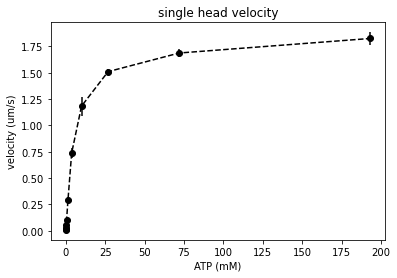

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  


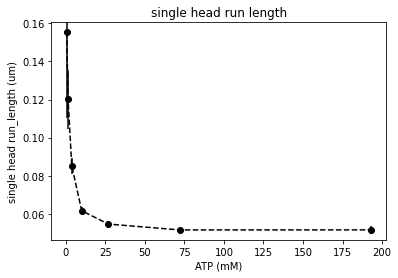

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  from ipykernel import kernelapp as app


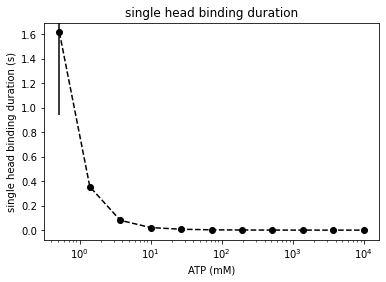

In [40]:
plt.errorbar(atps[:-4], vel[:-4], vel_err[:-4], fmt = 'k--o')
plt.xlabel('ATP (mM)')
plt.ylabel('velocity (um/s)')
#plt.gca().set_xscale('log')
plt.title('single head velocity')
plt.show()

plt.errorbar(atps[:-4], run_len[:-4], run_err[:-4], fmt = 'k--o')
plt.xlabel('ATP (mM)')
plt.ylabel('single head run_length (um)')
#plt.gca().set_xscale('log')
plt.title('single head run length')
plt.show()

plt.errorbar(atps, xlk_dur, dur_err, fmt = 'k--o')
plt.xlabel('ATP (mM)')
plt.ylabel('single head binding duration (s)')
plt.gca().set_xscale('log')
plt.title('single head binding duration')
plt.show()